In [1]:
!nvidia-smi
!pip install prefetch_generator
!pip install timm
!pip install albumentations

Sat Apr 22 20:03:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:1E.0 Off |                    0 |
|  0%   28C    P0    39W / 300W |      0MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import trange
import torchvision
import boto3
import io
import sagemaker
from sagemaker import get_execution_role
import tempfile
import PIL
import time
from datetime import timedelta
from prefetch_generator import BackgroundGenerator
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn import model_selection, metrics

In [3]:
# Make sure you're using cuda (GPU) by checking the hardware accelerator under Runtime -> Change runtime type
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using:", device)

We're using: cuda


# Download dataset from AWS S3

In [4]:
#!pip install cloudpathlib[s3,gs,azure]

In [5]:
#from cloudpathlib import CloudPath

#Download all the files from AWS S3
#Run this cell once if working in a new sagemaker instance
#This will take about 45 minutes to finish
#Use ls -l | grep "^-" | wc -l in terminal to check the number of files

#cp = CloudPath("s3://cassavaproject")
#cp.download_to("Dataset")

# Preprocessing

In [6]:
class MyDataset(Dataset):

    def __init__(self, df, transform=None):
        self.image_path = 'Dataset/train_images'
        self.labels = df
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = self.image_path + '/' + self.labels.iloc[idx]['image_id']

        # Read the image from the file path
        #image = Image.open(img_name)
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #Denoise, but we find that it is too slow.
        #image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

        
        # Transform the image using self.transform
        if self.transform:
            image = self.transform(image=image)["image"]

        if "label" in self.labels.columns:
            label = self.labels.iloc[idx]['label']
            sample = (image, label)
        else:
            sample = (image)
        return sample

In [7]:
#Used for directly download and read file from AWS S3.
#If running the download cell above, use 'MyDataset' class instead of this one.
class MyDatasetS3(Dataset):

    def __init__(self, transform=None):
        #File path for csv and images
        self.image_path = 'train_images'
        
        #Connect to s3 file
        self.csv_path = 'train.csv'
        self.s3_client = boto3.resource('s3')
        self.bucket = self.s3_client.Bucket('cassavaproject')
        
        s3 = boto3.client('s3')
        obj = s3.get_object(Bucket = 'cassavaproject',Key = 'train.csv')

        self.labels = pd.read_csv(obj['Body'])
        
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = self.image_path + '/' + self.labels.iloc[idx]['image_id']
        
        # we can download the file from S3 to a temporary file locally, then store that opened file as our image variable.
        # we need to create the local file name
        obj = self.bucket.Object(img_name)
        tmp = tempfile.NamedTemporaryFile()
        tmp_name = '{}.jpg'.format(tmp.name)

        # now we can actually download from S3 to a local place
        with open(tmp_name, 'wb') as f:
            obj.download_fileobj(f)
            f.flush()
            f.close()
            image = torchvision.io.read_file(tmp_name)
            image = torchvision.io.decode_jpeg(image, device="cpu")
            image = image.float()
            
        # Transform the image using self.transform
        if self.transform:
            image = self.transform(image)

        if "label" in self.labels.columns:
            label = self.labels.iloc[idx]['label']
            sample = (image, label)
        else:
            sample = (image)
        return sample

In [8]:
# Credit: https://www.kaggle.com/code/aliabdin1/calculate-mean-std-of-images/notebook
mean = np.array([0.42984136, 0.49624753, 0.3129598 ])
std = np.array([0.21417203, 0.21910103, 0.19542212])

In [9]:
albu_transform_train = A.Compose(
        [A.CenterCrop(height=256, width=256), 
         A.HorizontalFlip(p=0.5),
         A.VerticalFlip(p=0.5),
         A.RandomRotate90(p=0.5),
         A.RandomBrightnessContrast(p=0.8), 
         A.CoarseDropout(p=0.5),
         A.Normalize(mean=mean, std=std),
         ToTensorV2()
        ])

In [10]:
albu_transform_test = A.Compose(
        [A.CenterCrop(height=256, width=256),
         A.Normalize(mean=mean, std=std),
         ToTensorV2()
        ])

In [11]:
df = pd.read_csv('Dataset/train.csv')

train_df, test_df = model_selection.train_test_split(
    df, test_size=0.3, random_state=42, stratify=df.label.values
)

train_data = MyDataset(train_df, transform = albu_transform_train)
test_data = MyDataset(test_df, transform = albu_transform_test)

# Define our model

In [12]:
class BCNN(nn.Module):
  def __init__(self, num_classes):
    super(BCNN, self).__init__()
    features = torchvision.models.resnet34(weights='IMAGENET1K_V1')
    self.conv = nn.Sequential(*list(features.children())[:-2])
    self.fc = nn.Linear(512 * 512, num_classes)
    self.softmax = nn.Softmax()

  def forward(self, input):
    features = self.conv(input)
    features_size = features.size(2) * features.size(3)

    features = features.view(features.size(0), 512, features_size)

    features_T = torch.transpose(features, 1, 2)
    features = torch.bmm(features, features_T) / (features_size)

    features = features.view(features.size(0), 512 * 512)


    features = torch.sign(features) * torch.sqrt(torch.abs(features) + 1e-12)

    features = torch.nn.functional.normalize(features)


    out = self.fc(features)
    softmax = self.softmax(out)
    return softmax

# Loss Function

In [13]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1): 
        super(LabelSmoothingLoss, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.dim = dim 
    def forward(self, pred, target): 
        pred = pred.log_softmax(dim=self.dim) 
        with torch.no_grad(): 
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

# Train our model

In [14]:
model = nn.DataParallel(BCNN(5)).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6, amsgrad=False) #torch.optim.Adam(model.parameters(), lr=5*1e-3)


In [15]:
class DataLoaderX(DataLoader):

    def __iter__(self):
        return BackgroundGenerator(super().__iter__())

In [16]:
train_loader = DataLoaderX(dataset=train_data, batch_size = 128, shuffle= True, num_workers=2, pin_memory=True)
test_loader = DataLoaderX(dataset=test_data, batch_size = 128, shuffle=False, num_workers=2, pin_memory=True)

In [17]:
print('Start fine-tuning...')

Start fine-tuning...


In [18]:
def test_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            
            _,prediction = torch.max(outputs.data, 1)
            correct += (prediction == labels).sum().item()
            total += labels.size(0)
        model.train()
        return 100 * correct / total

In [19]:
def get_run_time(start_time):
    end_time = time.time()
    runtime = end_time - start_time
    return runtime

In [20]:
best_acc = 0.
best_epoch = None
end_patient = 0
num_epochs = 50
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

save_model_path = ''
train_loss = []
train_accuracy = []
test_accuracy = []

start_time = time.time()

#model = torch.compile(model)

for epoch in range(num_epochs):
    correct = 0
    total = 0
    epoch_loss = 0.
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss
        _, prediction = torch.max(outputs.data, 1)
        correct += (prediction == labels).sum().item()
        total += labels.size(0)
        
        time_diff = get_run_time(start_time)

        print('Epoch [{}/{}]: Iter {}, Loss {:.4f}, Runtime {:.0f}m {:.0f}s'.format(epoch + 1, num_epochs, i + 1, loss, time_diff//60, time_diff%60))
        train_loss.append(loss)
    
    train_acc = 100 * correct / total
    print('Testing on test dataset...')
    test_acc = test_model(model, test_loader)
    print('Epoch [{}/{}] Loss: {:.4f} Train_Acc: {:.4f}  Test_Acc: {:.4f}'
          .format(epoch + 1, num_epochs, epoch_loss, train_acc, test_acc))
    scheduler.step(test_acc)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    if test_acc > best_acc:
        best_acc = test_acc
        best_epoch = epoch + 1
        print('The accuracy is improved, save model')
        torch.save(model.state_dict(), os.path.join(
                                                    'resnet34_tuning_epoch_%d_acc_%g.pth' %
                                                    (best_epoch, best_acc)))

print('After the training, the end of the epoch %d, the accuracy %g is the highest' % (best_epoch, best_acc))

/tmp/ipykernel_22896/2441613066.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax = self.softmax(out)


Epoch [1/50]: Iter 1, Loss 1.6094, Runtime 0m 3s
Epoch [1/50]: Iter 2, Loss 1.6024, Runtime 0m 3s
Epoch [1/50]: Iter 3, Loss 1.5934, Runtime 0m 4s
Epoch [1/50]: Iter 4, Loss 1.5853, Runtime 0m 4s
Epoch [1/50]: Iter 5, Loss 1.5790, Runtime 0m 4s
Epoch [1/50]: Iter 6, Loss 1.5688, Runtime 0m 5s
Epoch [1/50]: Iter 7, Loss 1.5627, Runtime 0m 5s
Epoch [1/50]: Iter 8, Loss 1.5509, Runtime 0m 5s
Epoch [1/50]: Iter 9, Loss 1.5316, Runtime 0m 6s
Epoch [1/50]: Iter 10, Loss 1.5142, Runtime 0m 6s
Epoch [1/50]: Iter 11, Loss 1.5092, Runtime 0m 6s
Epoch [1/50]: Iter 12, Loss 1.4999, Runtime 0m 7s
Epoch [1/50]: Iter 13, Loss 1.4944, Runtime 0m 7s
Epoch [1/50]: Iter 14, Loss 1.4480, Runtime 0m 8s
Epoch [1/50]: Iter 15, Loss 1.4470, Runtime 0m 8s
Epoch [1/50]: Iter 16, Loss 1.4244, Runtime 0m 9s
Epoch [1/50]: Iter 17, Loss 1.4077, Runtime 0m 9s
Epoch [1/50]: Iter 18, Loss 1.4286, Runtime 0m 10s
Epoch [1/50]: Iter 19, Loss 1.4086, Runtime 0m 10s
Epoch [1/50]: Iter 20, Loss 1.4271, Runtime 0m 11s
Epoch 

# Result Analysis

In [21]:
import matplotlib.pyplot as plt
import itertools

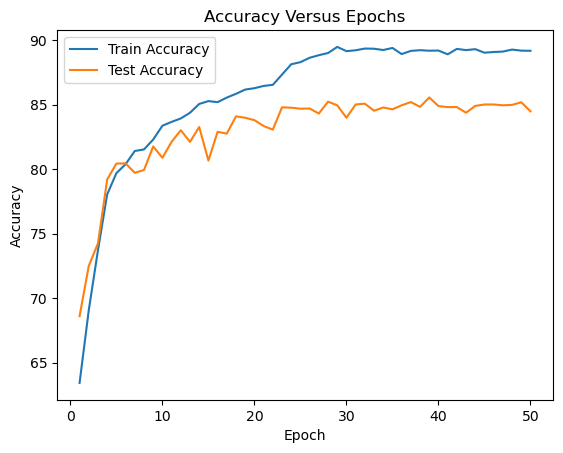

In [22]:
plt.plot(np.arange(1,51),train_accuracy,label='Train Accuracy')
plt.plot(np.arange(1,51),test_accuracy,label='Test Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Versus Epochs')
plt.show()

In [28]:
model = nn.DataParallel(BCNN(5)).to(device)
model.load_state_dict(torch.load('resnet34_tuning_epoch_39_acc_85.5607.pth'))


<All keys matched successfully>

In [29]:
test_model(model, test_loader)

/tmp/ipykernel_22896/2441613066.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax = self.softmax(out)


85.5607476635514

In [30]:
nb_classes = 5

confusion_matrix = torch.zeros(nb_classes, nb_classes)
model.eval()
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        #print(classes)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

/tmp/ipykernel_22896/2441613066.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax = self.softmax(out)


tensor([[ 155.,   30.,    4.,   22.,  115.],
        [  33.,  469.,   18.,   48.,   89.],
        [   8.,   21.,  491.,  128.,   68.],
        [   5.,   31.,   68., 3782.,   62.],
        [  55.,   32.,   22.,   68.,  596.]])


In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm/ np.sum(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2%' #if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Accuracy: 0.85560745


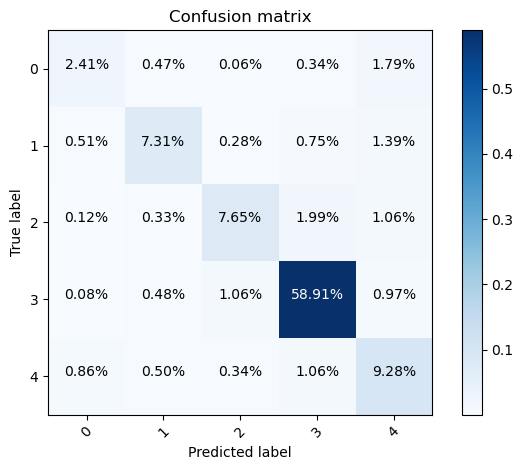

In [32]:
plt.figure()
num_classes=5
M = confusion_matrix.numpy()
plot_confusion_matrix(M, classes=np.arange(num_classes), normalize=True)
print("Accuracy:",np.trace(M/np.sum(M)))